In [1]:
import os
print(os.getcwd())
! pip install -r requirements.txt

c:\Users\ThinkPad\Desktop\code\FinRL_Meta\examples


In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
from finrl import config
from finrl import config_tickers
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent

# from pprint import pprint

# import itertools

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [3]:
df = YahooDownloader(start_date = '2008-01-01',
                     end_date = '2021-09-02',
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
USE_TURBULENCE=False
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=USE_TURBULENCE,
                    user_defined_feature = False)

df = fe.preprocess_data(df)
df.sample(5)

Successfully added technical indicators


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
46494,2014-12-10,36.930000,37.020000,36.299999,28.977631,27499900,INTC,2,0.718740,30.966833,26.352715,57.685891,61.262262,14.100124,28.017465,27.213249
58946,2009-09-18,56.599998,57.000000,56.299999,39.132710,14364400,MCD,4,0.064572,39.322062,37.229510,54.322862,118.277164,12.177444,38.137682,38.405516
88669,2018-05-29,48.299999,48.459999,47.860001,38.680210,13035300,VZ,1,0.048404,39.564985,37.512158,49.604622,-26.655571,3.867115,38.877624,38.490192
82864,2009-01-07,26.709999,27.080000,26.040001,21.641594,8228400,UNH,2,1.119329,23.763543,17.670650,55.145909,80.386830,10.535886,19.444521,18.652368
477,2009-11-20,7.112500,7.156786,7.062857,6.086264,406666400,AAPL,4,0.106488,6.419125,5.662346,58.588367,21.028147,5.259249,6.009445,5.736295


In [5]:
df.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
21933,2013-02-04,20.870001,21.129999,20.790001,15.232361,32053300,CSCO,0,0.168388,15.595235,14.772183,59.625960,72.677277,16.070745,14.999219,14.341270
8707,2015-03-31,77.889999,78.529999,77.620003,69.468765,5918300,AXP,1,-0.813794,73.801899,68.762289,41.731973,-144.846333,26.681106,71.454904,73.482351
4358,2011-08-19,50.790001,52.419998,50.740002,39.177040,9437000,AMGN,4,-0.853576,41.872063,36.318163,43.769904,-52.024562,30.456343,39.975322,41.895482
75711,2021-08-16,170.699997,172.399994,169.660004,169.941467,3530200,NKE,0,4.478655,174.275799,157.898833,69.488681,86.984387,38.307425,163.515582,149.490050
41356,2008-03-18,111.472275,113.221794,108.804970,70.313744,10424959,IBM,1,1.436132,71.425090,63.806403,62.638487,90.924453,27.190392,65.884476,63.798637


## Add covariance matrix as states

In [6]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)


df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [7]:
train = data_split(df, '2008-01-01','2020-01-1')
train.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
352,2010-05-26,25.415001,25.440001,24.969999,16.890396,32607800,KO,2,-0.269233,18.590560,17.031056,36.949571,-222.841588,54.301331,17.959992,18.142646,"[[0.00030695328281183054, 6.76071837663564e-05...",tic AAPL AMGN AXP ...
316,2010-04-06,32.619999,32.730000,32.419998,24.159986,9399600,HD,1,0.366815,24.514080,23.632958,63.755537,64.833933,33.554278,23.763642,22.424019,"[[0.00029173529264149247, 5.714040705958599e-0...",tic AAPL AMGN AXP ...
1058,2013-03-18,69.329033,70.806755,69.166962,57.742729,4467523,HON,0,1.106377,58.750799,52.905179,69.151721,130.588508,34.515046,55.350542,53.444609,"[[0.00042141706035861166, 5.838306231731916e-0...",tic AAPL AMGN AXP ...
451,2010-10-15,34.700001,34.869999,34.310001,24.756151,6055600,WBA,4,0.991957,26.261998,20.576373,67.075598,90.283085,58.131147,22.508430,21.333043,"[[0.0003255369495247228, 9.679968342026554e-05...",tic AAPL AMGN AXP ...
2249,2017-12-06,43.139999,43.720001,42.669998,37.827381,27710800,INTC,2,0.201364,40.622316,37.640740,55.724908,-110.040208,25.648717,39.086243,36.279227,"[[0.00011937420928238037, 3.2419060775440564e-...",tic AAPL AMGN AXP ...



## Environment for Portfolio Allocation


In [8]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A portfolio allocation environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        # self.state = [self.data[tech].values.tolist() for tech in self.tech_indicator_list]

        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            # if turbulence>self.turbulence_threshold
            return self.state, self.reward, self.terminal,{}

        else:
            weights = self.softmax_normalization(actions) 
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            # self.state = [self.data[tech].values.tolist() for tech in self.tech_indicator_list ]
        
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            log_portfolio_return = np.log(sum((self.data.close.values / last_day_memory.close.values)*weights))
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value
            

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        # self.state = [self.data[tech].values.tolist() for tech in self.tech_indicator_list]
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [9]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
feature_dimension = len(tech_indicator_list)
print(f"Feature Dimension: {feature_dimension}")

Stock Dimension: 28, State Space: 28
Feature Dimension: 4


In [10]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-1
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [11]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


### Model 1: **A2C**


In [12]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 10, "ent_coef": 0.005, "learning_rate": 0.0004}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 10, 'ent_coef': 0.005, 'learning_rate': 0.0004}
Using cpu device


In [13]:
trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c',
                                total_timesteps=10)

### Model 2: **PPO**


In [14]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.001, 'batch_size': 128}
Using cpu device


In [15]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=10)

----------------------------------
| time/              |           |
|    fps             | 144       |
|    iterations      | 1         |
|    time_elapsed    | 14        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 4142209.2 |
----------------------------------


In [16]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {
    "buffer_size": 10_000,
    "learning_rate": 0.0005,
    "batch_size": 64
}
model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'buffer_size': 10000, 'learning_rate': 0.0005, 'batch_size': 64}
Using cpu device


In [17]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=10)

begin_total_asset:1000000
end_total_asset:6754534.33570759
Sharpe:  1.1814982166630992


## Back-Testing
Assume that we have $1,000,000 initial capital at 2020-01-01. We use the PPO, A2C, SVM, Linear Regression, Decision Tree, Random Foreset models to trade Dow jones 30 constituent stocks.


In [18]:
trade = data_split(df,'2020-01-01', '2021-01-01')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [19]:
import torch
%matplotlib inline
import plotly.express as px


In [20]:
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [21]:
%matplotlib inline
from finrl.plot import get_baseline
from copy import deepcopy

def get_daily_return(df, value_col_name="account_value"):
    df = deepcopy(df)
    df["daily_return"] = df[value_col_name].pct_change(1)
    df["date"] = pd.to_datetime(df["date"])
    return pd.DataFrame(df[['date','daily_return']])

baseline_df = get_baseline(
        ticker="^DJI", 
        start = '2020-01-01',
        end =  '2021-01-01')

baseline_returns = get_daily_return(baseline_df, value_col_name="close")
baseline_returns['daily_return'][0]=0.000000
dji_cumpod =(baseline_returns['daily_return']+1).cumprod()-1
print('*'*100, dji_cumpod)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)
**************************************************************************************************** 0      0.000000
1     -0.008103
2     -0.005730
3     -0.009876
4     -0.004285
         ...   
248    0.046108
249    0.053177
250    0.050812
251    0.053371
252    0.060192
Name: daily_return, Length: 253, dtype: float64


In [22]:
df_daily_return_a2c, df_actions_a2c = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)
df_daily_return_ppo, df_actions_ppo = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)
df_daily_return_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(model=trained_ddpg,
                        environment = e_trade_gym)
print(df_daily_return_a2c,df_daily_return_ppo,df_daily_return_ddpg)
time_ind = pd.Series(df_daily_return_a2c.date)

begin_total_asset:1000000
end_total_asset:1118809.624962168
Sharpe:  0.4935190669760394
hit end!
begin_total_asset:1000000
end_total_asset:1117555.9065777361
Sharpe:  0.4903026551282727
hit end!
begin_total_asset:1000000
end_total_asset:1129889.2884536937
Sharpe:  0.5207275154385624
hit end!
           date  daily_return
0    2020-01-02      0.000000
1    2020-01-03     -0.008265
2    2020-01-06      0.002992
3    2020-01-07     -0.005405
4    2020-01-08      0.002914
..          ...           ...
248  2020-12-24      0.001844
249  2020-12-28      0.006335
250  2020-12-29     -0.001536
251  2020-12-30      0.001093
252  2020-12-31      0.007037

[253 rows x 2 columns]            date  daily_return
0    2020-01-02      0.000000
1    2020-01-03     -0.008218
2    2020-01-06      0.002999
3    2020-01-07     -0.005398
4    2020-01-08      0.002806
..          ...           ...
248  2020-12-24      0.001835
249  2020-12-28      0.006234
250  2020-12-29     -0.001521
251  2020-12-30      0.

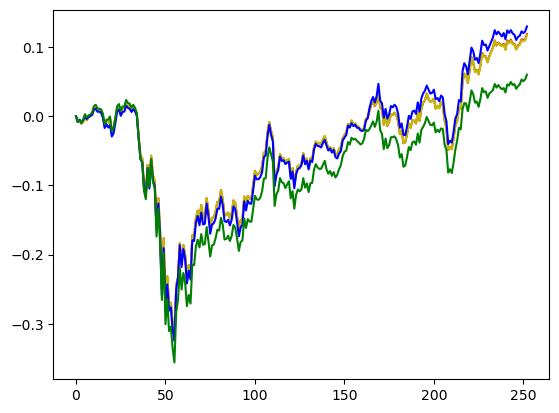

In [23]:
a2c_cumpod =(df_daily_return_a2c.daily_return+1).cumprod()-1
ppo_cumpod =(df_daily_return_ppo.daily_return+1).cumprod()-1
ddpg_cumpod =(df_daily_return_ddpg.daily_return+1).cumprod()-1

path = './results/csv'
if not os.path.isdir(path):
    os.mkdir(path)
if USE_TURBULENCE:
    a2c_cumpod.to_csv(os.path.join(path,'a2c_tur.csv'))
    ppo_cumpod.to_csv(os.path.join(path,'ppo_tur.csv'))
    ddpg_cumpod.to_csv(os.path.join(path,'ddpg_tur.csv'))
    dji_cumpod.to_csv(os.path.join(path,'dji.csv'))
else:
    a2c_cumpod.to_csv(os.path.join(path,'a2c_no_tur.csv'))
    ppo_cumpod.to_csv(os.path.join(path,'ppo_no_tur.csv'))
    ddpg_cumpod.to_csv(os.path.join(path,'ddpg_no_tur.csv'))
    dji_cumpod.to_csv(os.path.join(path,'dji.csv'))


plt.plot(a2c_cumpod,'r')
plt.plot(ppo_cumpod,'y')
plt.plot(ddpg_cumpod,'b')
plt.plot(dji_cumpod,'g')

In [24]:
(pd.Series([1,2,3,4])).cumprod()

0     1
1     2
2     6
3    24
dtype: int64